# NLP Bag of Words model
- used to preprocess text for higher level NLP tasks
- predict if a review is positive or negative
- tsv is tab separated value
- use nltk https://www.nltk.org/

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords #must download stopwords before first use
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
### Functions

In [55]:
def removeWords(wordList):
    return [word for word in review if not word in set(stopwords.words('english'))]

def preprocess(string, ps):
    """
    Removes non letters, turns to lowercase, removes stop words, performs stemming
    not is a stop word but it has relevance in some cases so it is accounted for here
    """
    string = re.sub('[^a-z]', ' ', string.lower())
    string = string.split()
    string = [ps.stem(word) for word in string if not (word in set(stopwords.words('english')) and word != "not")]
    return ' '.join(string)

In [98]:
from scipy import integrate

def capcurve(y_test, y_pred):
    y_values = y_test
    y_preds_proba = y_pred
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)

    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8,6))
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()

### Get the dataset

In [3]:
df = pd.read_csv("Restaurant_Reviews.tsv", delimiter='\t', quoting=3) #quoting=3 -> ignore double quotes
rows = len(df)
cols = len(df.keys())
print(rows,cols)
df.head()

1000 2


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Clean the data
- remove all non letters and convert to lowercase

In [13]:
review = re.sub('[^a-z]', ' ', df['Review'][0].lower())
review

'wow    loved this place '

- remove non important words like articles, prepositions, etc (stopwords)

In [22]:
#nltk.download('stopwords')

In [14]:
review = review.split()
review

['wow', 'loved', 'this', 'place']

In [20]:
review = removeWords(review)
review

['wow', 'loved', 'place']

- perform stemming (getting the root of a word)

In [24]:
ps = PorterStemmer()
review = [ps.stem(word) for word in review]
review

['wow', 'love', 'place']

- join back to a single string

In [25]:
review = ' '.join(review)
review

'wow love place'

#### Do it for all the reviews now

In [56]:
corpus = []
for i in range(0, rows):
    processed = preprocess(df['Review'][i], ps)
    corpus.append(processed)
corpus[0:5]

['wow love place',
 'crust not good',
 'not tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

### Create the bag of words model
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [104]:
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### Fit to a naive bayes model
- https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

In [105]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### Predict and evaluate

In [106]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

In [107]:
print(acc)
print(cm)

0.71
[[51 44]
 [14 91]]


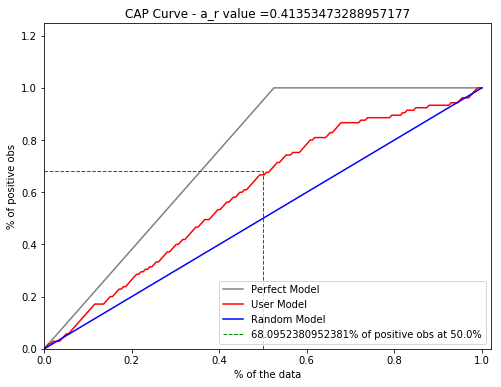

In [108]:
capcurve(y_test, y_pred)

### Try with random forest classifier

In [109]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [110]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print(acc)

[[88  7]
 [46 59]]
0.735


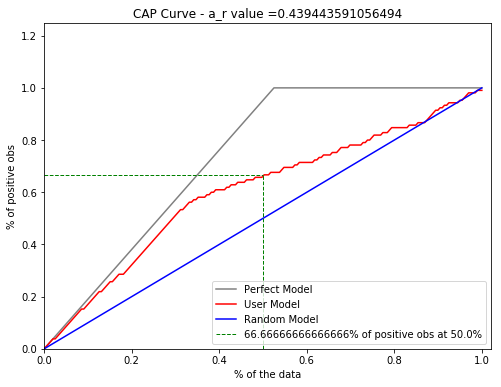

In [111]:
capcurve(y_test, y_pred)

### Try optimizing the hyperparameters for random forest
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

In [144]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 50),
              "min_samples_split": sp_randint(2, 30),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": sp_randint(10,40)}

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=6)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 44.76 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.807 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 11, 'n_estimators': 21}

Model with rank: 2
Mean validation score: 0.806 (std: 0.026)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 20, 'min_samples_split': 5, 'n_estimators': 21}

Model with rank: 3
Mean validation score: 0.805 (std: 0.023)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 25, 'n_estimators': 35}

Model with rank: 3
Mean validation score: 0.805 (std: 0.013)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 31, 'min_samples_split': 19, 'n_estimators': 18}



/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


- select the parameters with the best fit

In [150]:
clf = RandomForestClassifier(bootstrap=False, 
                             criterion='gini', 
                             max_depth=None, 
                             max_features=5, 
                             min_samples_split=11, 
                             n_estimators=21)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(acc)
print(cm)

0.795
[[82 13]
 [28 77]]


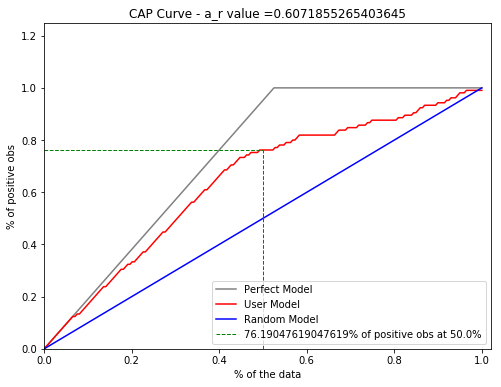

In [152]:
capcurve(y_test, y_pred)